# Classification of images of digits

## Librairies

In [102]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras.utils import plot_model
from scikeras.wrappers import KerasClassifier
import random as python_random
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from scipy.stats import wilcoxon

# Visualization
import matplotlib.pyplot as plt

## Data loading

In [103]:
train_images = np.load("train_images.npy")
train_labels = np.load("train_labels.npy")
test_images = np.load("test_images.npy")
test_labels = np.load("test_labels.npy")

print("train_images shape:", train_images.shape)
print("train_labels shape:", train_labels.shape)
print("test_images shape:", test_images.shape)
print("test_labels shape:", test_labels.shape)

print(train_labels[:10])

train_images shape: (60000, 28, 28, 1)
train_labels shape: (60000,)
test_images shape: (10000, 28, 28, 1)
test_labels shape: (10000,)
[5 0 4 1 9 2 1 3 1 4]


The shape of the dataset is correct.

## Visualization of a few images

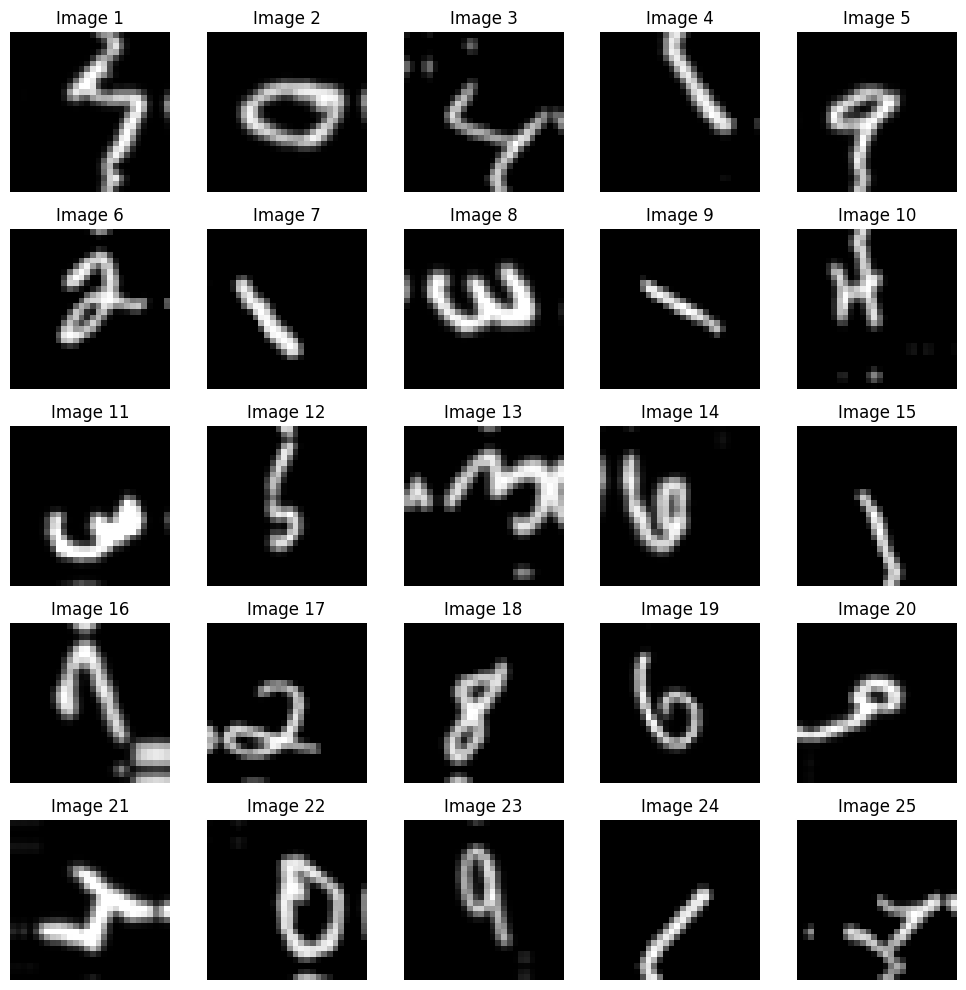

In [104]:
# Visualize the first 20 images of the dataset
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(f"Image {i+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Data preprocessing

### Check the data type

In [105]:
print("train_images dtype:", train_images.dtype, "; train_labels dtype:", train_labels.dtype)
print("test_images dtype:", test_images.dtype, "; test_labels dtype:", test_labels.dtype)

train_images dtype: float32 ; train_labels dtype: uint8
test_images dtype: uint8 ; test_labels dtype: uint8


The test_image dataset type needs to be converted to float32.

### Data type conversion

In [106]:
test_images = test_images.astype(np.float32)

print("test_images dtype:", test_images.dtype)

test_images dtype: float32


#### Check the normalisation of both dataset

In [107]:
# Check that the test set and the training set have the same average pixel value
print("Train images mean:", train_images.mean())
print("Test images mean:", test_images.mean())

print("Train images range:", train_images.min(), train_images.max())
print("Test images range:", test_images.min(), test_images.max())


Train images mean: 0.14200264
Test images mean: 36.074966
Train images range: 0.0 1.0
Test images range: 0.0 255.0


The test dataset needs normalization. 

In [108]:
# Normalize the values of the test dataset
test_images = test_images / 255.0

# Validate the normalization
print("Test images mean:", test_images.mean())
print("Test images range:", test_images.min(), test_images.max())


Test images mean: 0.14147049
Test images range: 0.0 1.0


## One-hot encoding of the labels

In [109]:
num_classes = np.unique(train_labels).shape[0]
print("Number of classes:", num_classes)
print("classes:", np.unique(train_labels))

train_labels = keras.utils.to_categorical(train_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)

print("train_labels shape:", train_labels.shape)
print("test_labels shape:", test_labels.shape)
print("some train_labels:", train_labels[:10])

Number of classes: 10
classes: [0 1 2 3 4 5 6 7 8 9]
train_labels shape: (60000, 10)
test_labels shape: (10000, 10)
some train_labels: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


#### Shuffle the data

In [110]:
ns =  train_images.shape[0] #number of examples
np.random.seed()
shuffle_index = np.random.permutation(ns)
train_images, train_labels = train_images[shuffle_index,:], train_labels[shuffle_index,]

print("train_images shape:", train_images.shape)
print("train_labels shape:", train_labels.shape)
print("test_images shape:", test_images.shape)
print("test_labels shape:", test_labels.shape)

train_images shape: (60000, 28, 28, 1)
train_labels shape: (60000, 10)
test_images shape: (10000, 28, 28, 1)
test_labels shape: (10000, 10)


# Descriptive statistics

## Visualize the distribution of the different classes

Number of samples per class: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


<BarContainer object of 10 artists>

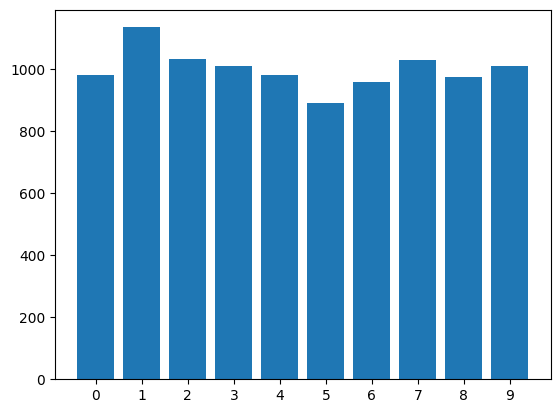

In [111]:
# Verify that the data is balanced
labels = test_labels.argmax(axis=1)
counts = np.bincount(labels)
print("Number of samples per class:", counts)


# Plot a barplot of the labels
plt.bar(range(10), counts, tick_label=range(10))


The data are quite balanced, there is no need to use class weights during the training.

# Dense NN construction

In [112]:
num_pixels = train_images.shape[1] * train_images.shape[2] #784
print("num_pixels:", num_pixels)

num_pixels: 784


### Model construction

In [113]:
def dnn():
    # Define the model
    model = keras.Sequential([

        layers.Flatten(input_shape=(28, 28)),

        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='rmsprop', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
                  
    return model

model = dnn()

/home/jmaes/miniconda3/envs/bioinfo/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Visualize the model

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_28 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,146 (918.54 KB)

 Trainable params: 235,146 (918.54 KB)

 Non-trainable params: 0 (0.00 B)

None


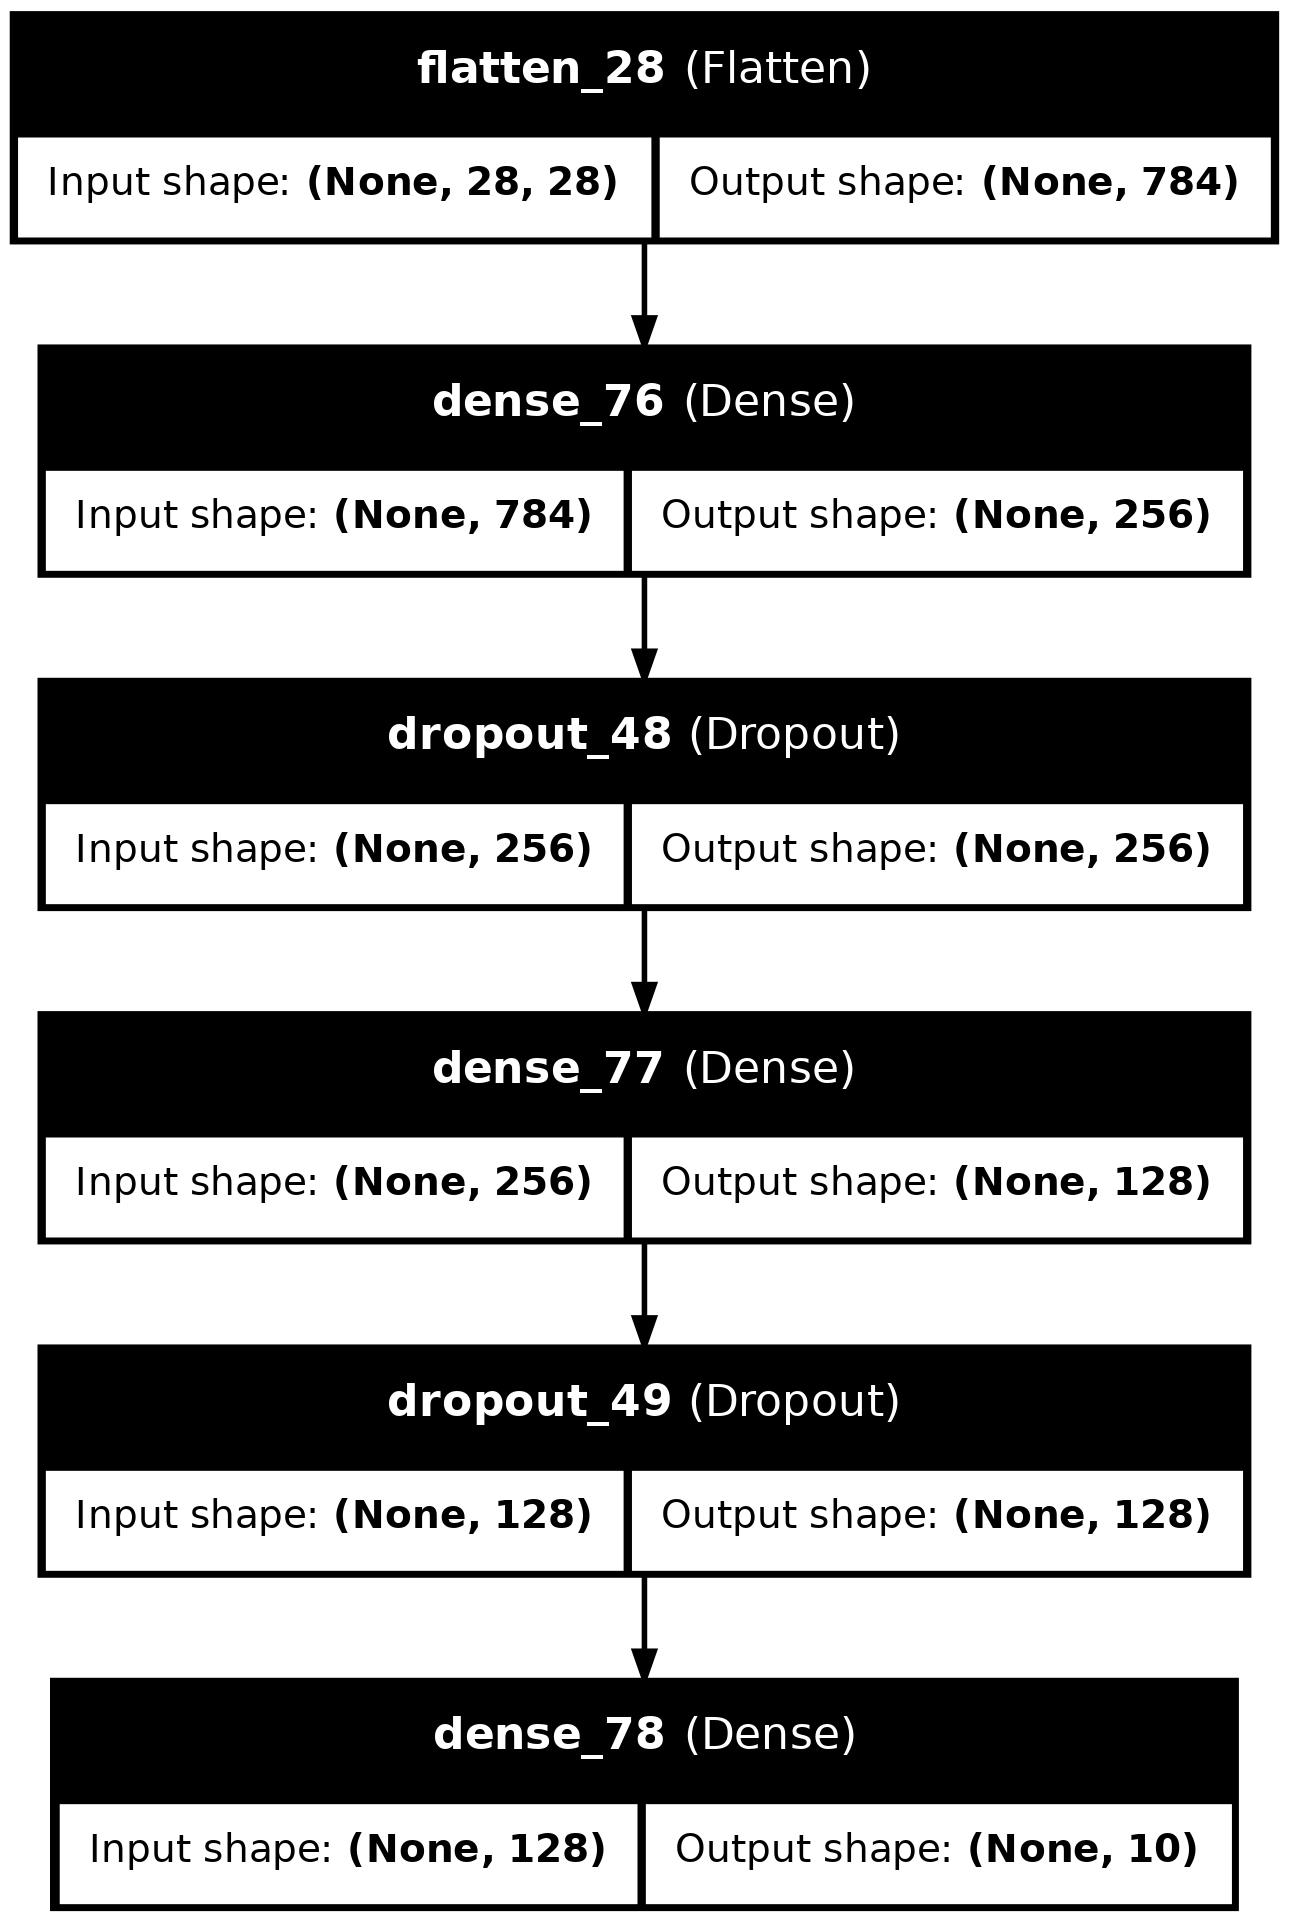

In [114]:
print(model.summary())

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

            

### Definition of the seed function for reproductibility

In [115]:
def reset_seeds(seed = 42):
   np.random.seed(seed) 
   python_random.seed(seed)
   tf.random.set_seed(seed)

### Train the model

In [116]:
# set the seed
reset_seeds()

# Train the model
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    train_images, 
    train_labels, 
    epochs=50, 
    batch_size=64, 
    validation_split=0.2,
    callbacks=[early_stopping])

Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.2731 - loss: 2.0195 - val_accuracy: 0.5767 - val_loss: 1.3182
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5391 - loss: 1.3717 - val_accuracy: 0.6671 - val_loss: 1.0417
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6093 - loss: 1.1767 - val_accuracy: 0.7016 - val_loss: 0.9416
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6458 - loss: 1.0729 - val_accuracy: 0.7327 - val_loss: 0.8494
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.6764 - loss: 0.9941 - val_accuracy: 0.7481 - val_loss: 0.8016
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6896 - loss: 0.9576 - val_accuracy: 0.7635 - val_loss: 0.7574
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7063 - loss: 0.9128 - val_accuracy: 0.7692 - val_loss: 0.7415
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7199 - loss: 0.8862 - val_accuracy: 0.

### Evaluate the model on the test set

In [117]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8254 - loss: 0.6432
Test accuracy: 0.8381999731063843


### Visualize the evolution of accuracy and loss during training

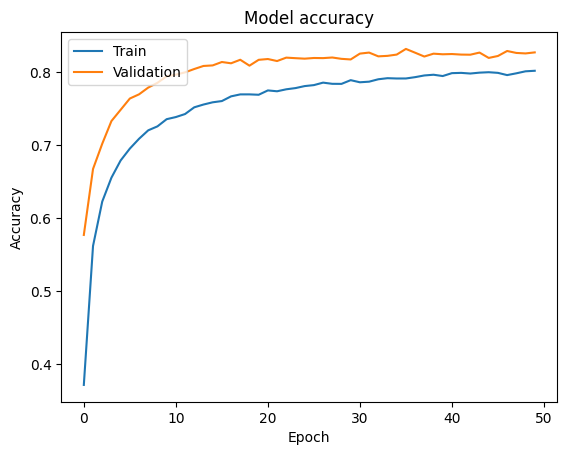

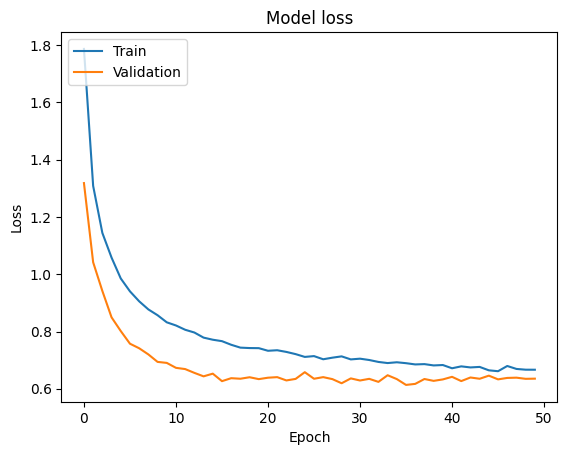

In [118]:
#print(history.history.keys())
def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history)

The accuracy is fine, but underfitting a bit. 
The model performs better on the validation set rather than on the training set.

### Confusion matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


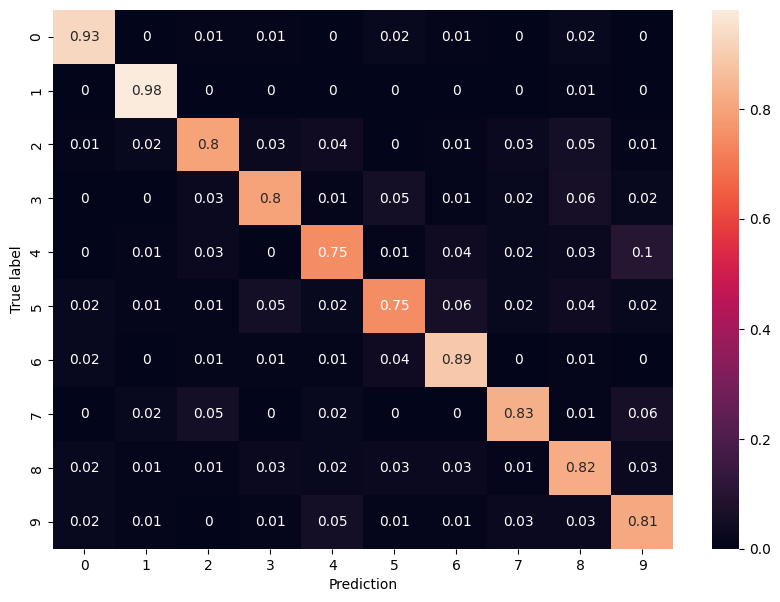

In [119]:
# generate confusion matrix
predictions = model.predict(test_images)
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1), normalize='true')
conf_matrix = np.round(conf_matrix, 2)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.show()


The performances are quite good. 
The model mixes up 4 and 9. 

## 2D CNN

### Create the architecture of the model

In order to improve the performance of a simple dense NN, we are going to implement a CNN. 

In [120]:
# create a CNN with 3 convolutional layers and 2 dense layers with dropout
def cnn():
    model = keras.Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(.3),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(.3),


    # better curve shape but lower accuracy : comment the following lines
    layers.Conv2D(132, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(.3),

    # layers.Conv2D(132, (1, 1), activation='relu'),
    # layers.BatchNormalization(),
    # layers.MaxPooling2D((2, 2)),
    # layers.Dropout(.3),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.3),

    layers.Dense(10, activation='softmax')
])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model_CNN_1 = cnn()



/home/jmaes/miniconda3/envs/bioinfo/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Visualize the model

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 3, 3, 132)      │        76,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 3, 3, 132)      │           528 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 1, 1, 132)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 132)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 64)             │         8,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,798 (409.37 KB)

 Trainable params: 104,470 (408.09 KB)

 Non-trainable params: 328 (1.28 KB)

None


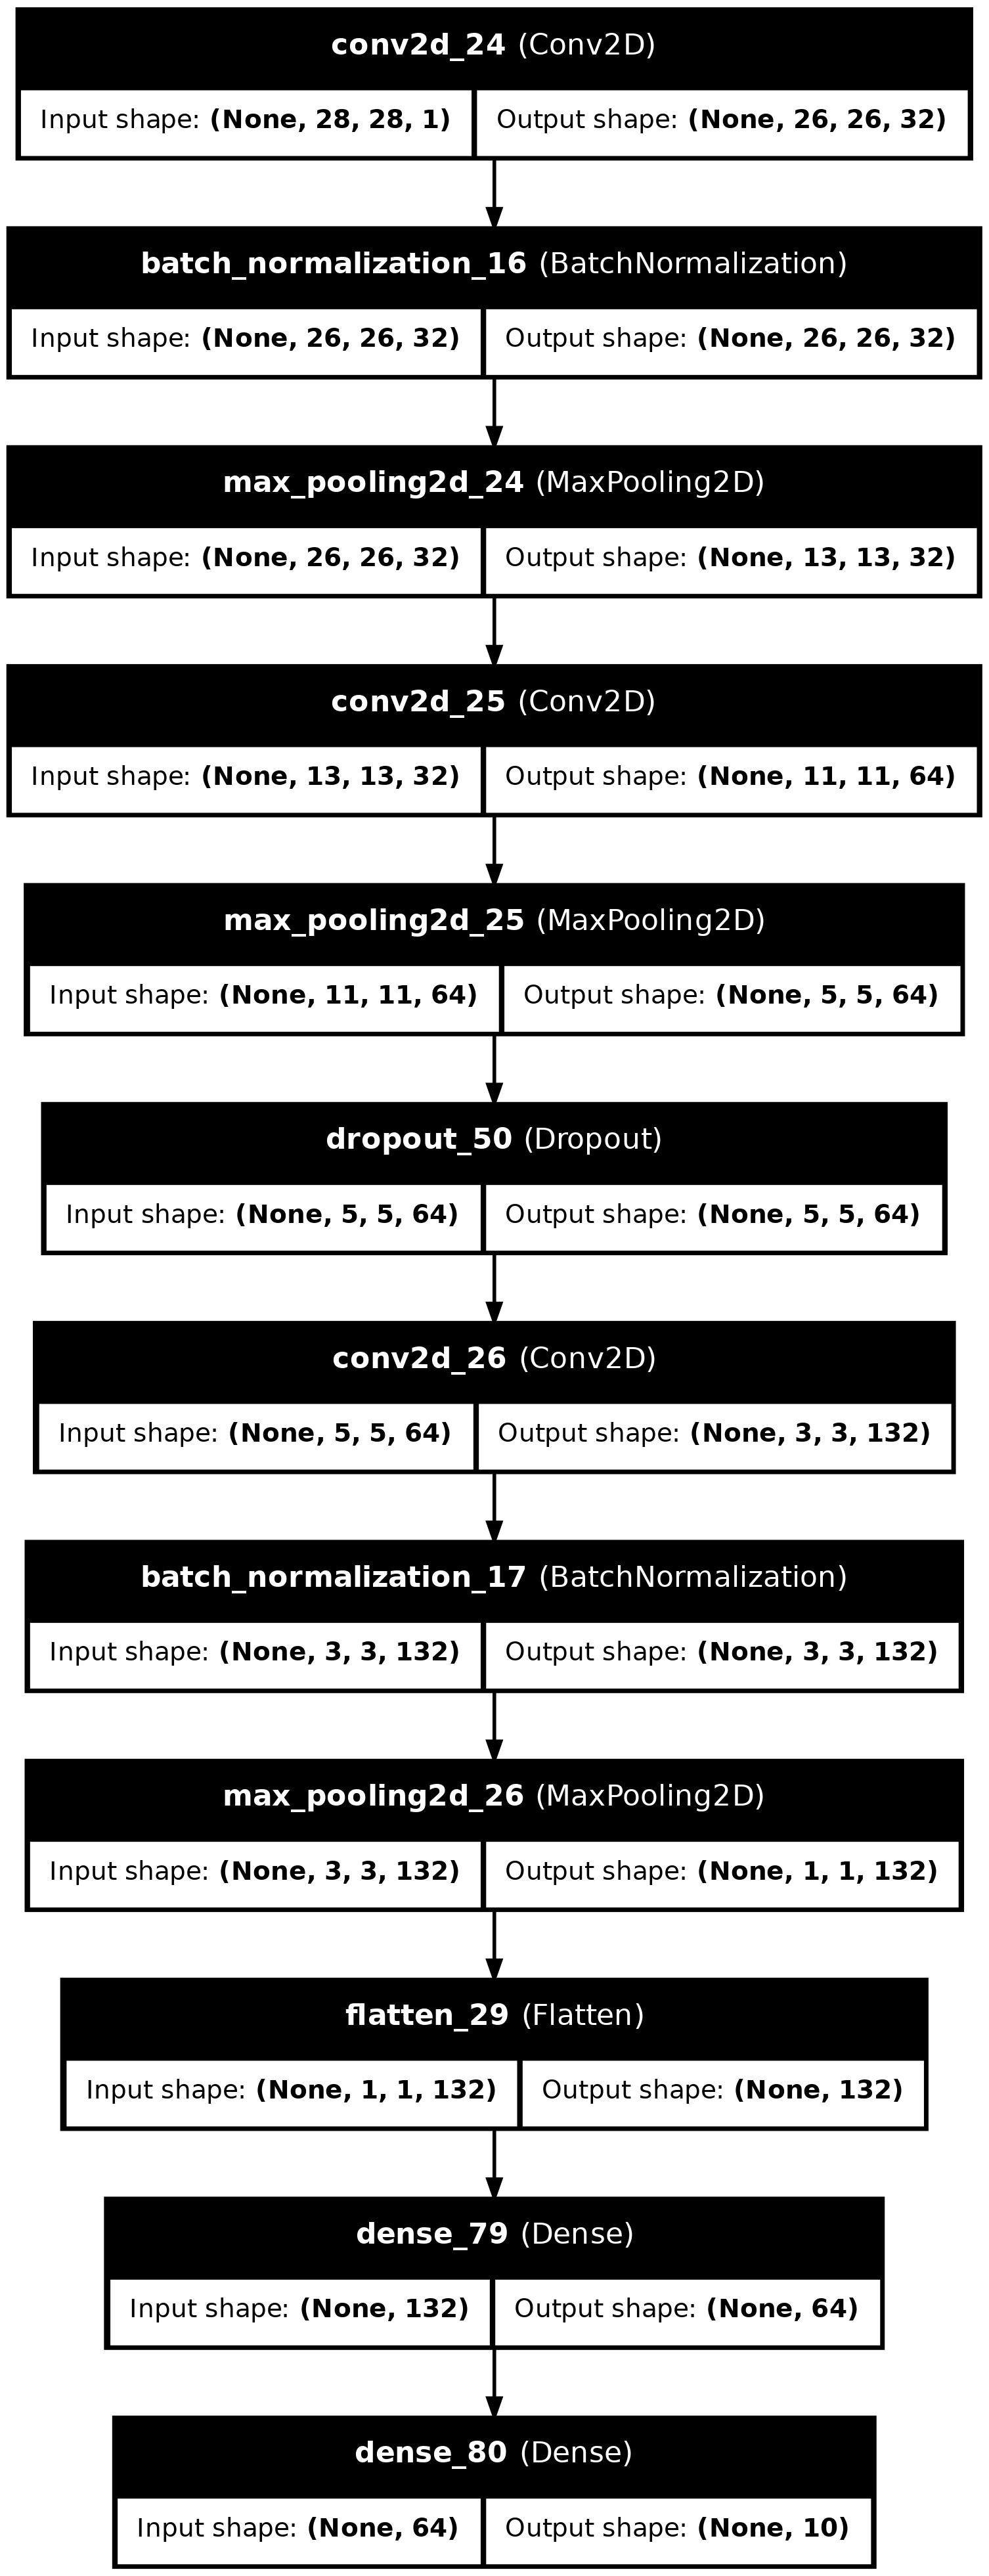

In [121]:
print(model_CNN_1.summary())

plot_model(model_CNN_1, to_file='model_plot_CNN.png', show_shapes=True, show_layer_names=True)

            

### Train the CNN

In [122]:
# reset the seed
reset_seeds(50)

# train the model
early_stopping = keras.callbacks.EarlyStopping(
    patience=8,
    min_delta=0.001,
    restore_best_weights=True,
)
history_CNN_1 = model_CNN_1.fit(
    train_images, 
    train_labels, 
    epochs=50, 
    batch_size=128, 
    validation_split=0.2,
    callbacks=[early_stopping])

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4942 - loss: 1.4789 - val_accuracy: 0.7205 - val_loss: 0.9088
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.8368 - loss: 0.5107 - val_accuracy: 0.8803 - val_loss: 0.3624
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.8750 - loss: 0.3878 - val_accuracy: 0.8925 - val_loss: 0.3258
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.8961 - loss: 0.3256 - val_accuracy: 0.9124 - val_loss: 0.2695
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.9071 - loss: 0.2928 - val_accuracy: 0.9235 - val_loss: 0.2425
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9178 - loss: 0.2534 - val_accuracy: 0.9212 - val_loss: 0.2521
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9193 - loss: 0.2490 - val_accuracy: 0.9227 - val_loss: 0.2495
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - accuracy: 0.9243 - loss: 0.2274 - 

### Analyze performances on the test set

In [123]:
test_loss, test_acc = model_CNN_1.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9285 - loss: 0.2345
Test accuracy: 0.9383000135421753


### Visualize the evolution of accuracy and loss during training

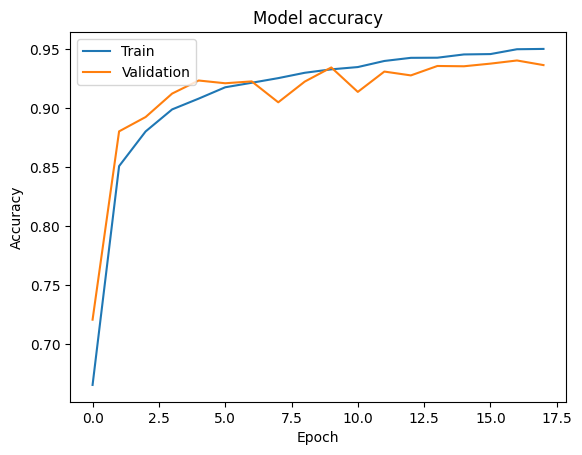

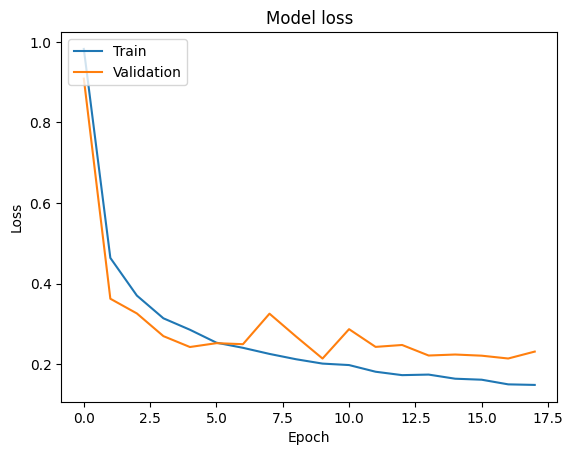

In [124]:
# Visualize the training history
plot_history(history_CNN_1)

Performances are better for the CNN than for the DNN (92 vs 82 %). 

We could stil try to improve the performances. 

To do so : 

Increase the size of the last conv layer : 64 to 132


add a additional layer of 64 kernels before the conv layer of 132.

Remove drop out for some of the layers. 


Increase learning rate : 0.001 to 0.005


### Confusion matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


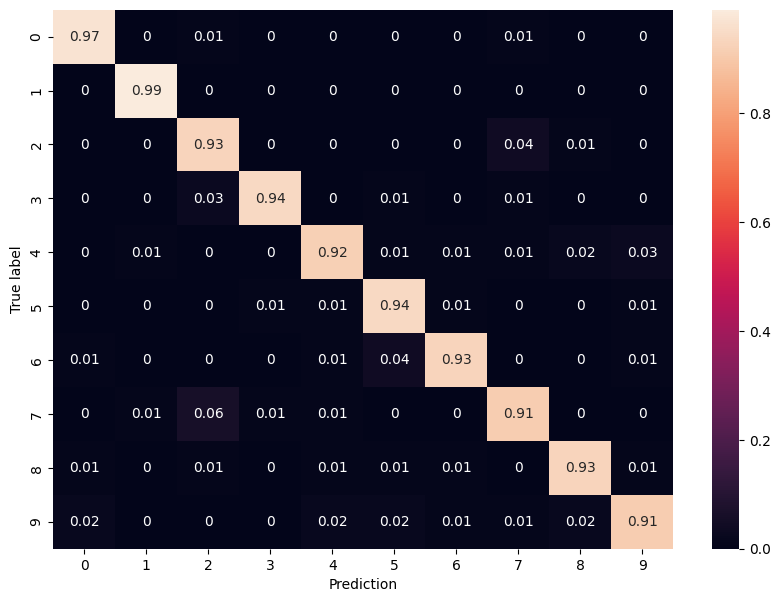

In [26]:
# generate confusion matrix
predictions = model_CNN_1.predict(test_images)
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1), normalize='true')
conf_matrix = np.round(conf_matrix, 2)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.show()

# 5-fold Cross Validation and statistical comparison of the models

## DNN

### Perform the cross validation

Here I didn't use the call back and stopped the training after 35 epochs, for homogenous matrix shape reason

In [70]:
# Variable to store the best model
best_model = None
model_folds = []
best_accuracy = 0
fold_losses = []
fold_accuracies = []

# Callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

# K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True)

for train_index, val_index in kfold.split(train_images):
    print("Processing fold", len(fold_accuracies) + 1)
    # Split the data
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Create the model
    model = dnn()

    # Train the model
    reset_seeds()
    history = model.fit(
        X_train, 
        y_train, 
        epochs=35, 
        batch_size=64, 
        validation_data=(X_val, y_val),
        verbose=0,
        #callbacks=[early_stopping]
    )

    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val)

    # Save the model
    model_folds.append(model)

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        print("New best accuracy:", best_accuracy, "for fold", len(fold_accuracies) + 1)

    # Save the loss and accuracy
    fold_losses.append(history.history['val_loss'])
    fold_accuracies.append(history.history['val_accuracy'])

Processing fold 1
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8253 - loss: 0.6252
New best accuracy: 0.8274999856948853 for fold 1
Processing fold 2
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8203 - loss: 0.6465
Processing fold 3
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8279 - loss: 0.6442
Processing fold 4
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8128 - loss: 0.6551
Processing fold 5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8200 - loss: 0.6221


### Show 5-fold CV results

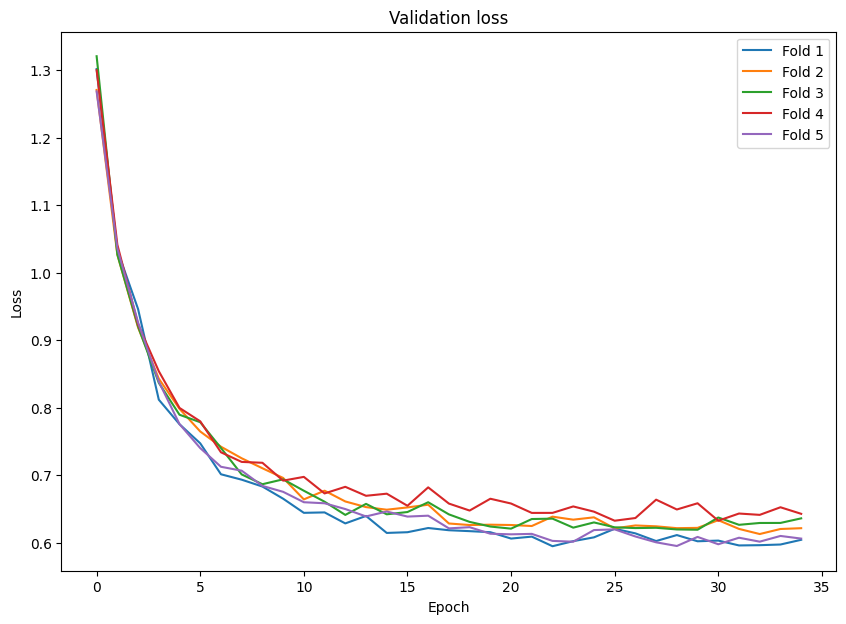

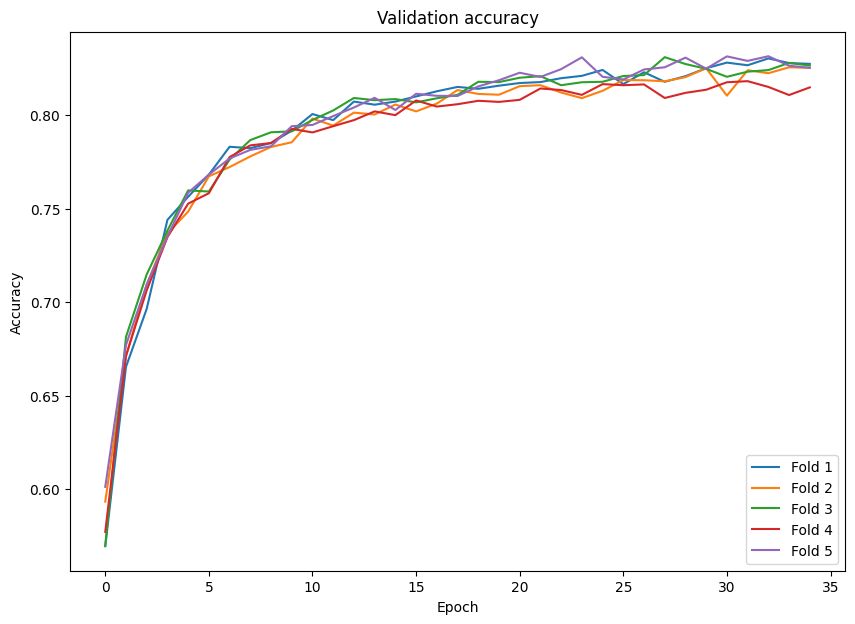

In [71]:
# Plot the loss and accuracy for each fold on the same plot
plt.figure(figsize=(10, 7))
for i in range(len(fold_losses)):
    plt.plot(fold_losses[i], label=f"Fold {i+1}")
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(10, 7))
for i in range(len(fold_accuracies)):
    plt.plot(fold_accuracies[i], label=f"Fold {i+1}")
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()



### Extraction of stats

In [72]:
all_accuracies = np.array([np.array(a) for a in fold_accuracies])
all_losses = np.array([np.array(l) for l in fold_losses])

# print last accuracy and loss
print((all_accuracies[:,-1]))
print((all_losses[:,-1]))

# extract mean and std of the accuracies of the last epoch
mean_accuracy = np.mean(all_accuracies[:,-1])
std_accuracy = np.std(all_accuracies[:,-1])
print("Mean accuracy:", mean_accuracy)
print("Std accuracy:", std_accuracy)


[0.82749999 0.82541668 0.82658333 0.81491667 0.82533336]
[0.60464096 0.62182218 0.63638067 0.64310724 0.60643655]
Mean accuracy: 0.8239500045776367
Std accuracy: 0.004586996559631198


### Test performances on the test set

In [75]:
# Evaluate the best model on the test set
accuracies_test = []
losses_test = []
for model in model_folds:
    loss, accuracy = model.evaluate(test_images, test_labels)
    accuracies_test.append(accuracy)
    losses_test.append(loss)

print("Test accuracies:", accuracies_test)
print("Test losses:", accuracies_test)

# Get mean and std of the test accuracies and losses
mean_test_accuracy = np.mean(accuracies_test)
std_test_accuracy = np.std(accuracies_test)
mean_test_loss = np.mean(losses_test)
std_test_loss = np.std(losses_test)



print("Mean test accuracy:", mean_test_accuracy, "Std:", std_test_accuracy)
print("Mean test loss:", mean_test_loss, "Std:", std_test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8246 - loss: 0.6352
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8211 - loss: 0.6589
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8231 - loss: 0.6503
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8194 - loss: 0.6337
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8225 - loss: 0.6377
Test accuracies: [0.838699996471405, 0.8370000123977661, 0.8374000191688538, 0.8292999863624573, 0.833299994468689]
Test losses: [0.838699996471405, 0.8370000123977661, 0.8374000191688538, 0.8292999863624573, 0.833299994468689]
Mean test accuracy: 0.8351400017738342 Std: 0.003427310528148006
Mean test loss: 0.5857409000396728 Std: 0.006300879110727117


## CNN

### 5-fold cross validation of the CNN

#### CV

Here, i didn't use the call back function, but stopped the iterations at 25 epochs. Same as before, this is done so that the output matrix of accuracies and loss always have the same shape.

In [76]:
# Variable to store the best model
best_model = None
model_folds = []
best_accuracy = 0
fold_losses = []
fold_accuracies = []

# Callback for early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

# K-fold cross validation
kfold = KFold(n_splits=5, shuffle=True)

for train_index, val_index in kfold.split(train_images):
    print("Processing fold", len(fold_accuracies) + 1)
    # Split the data
    X_train, X_val = train_images[train_index], train_images[val_index]
    y_train, y_val = train_labels[train_index], train_labels[val_index]

    # Create the model
    model = cnn()

    # Train the model
    reset_seeds()
    history = model.fit(
        X_train, 
        y_train, 
        epochs=25, 
        batch_size=128, 
        validation_data=(X_val, y_val),
        verbose=0,
        #callbacks=[early_stopping]
    )

    # Evaluate the model
    _, accuracy = model.evaluate(X_val, y_val)

    # Save the model
    model_folds.append(model)

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        print("New best accuracy:", best_accuracy, "for fold", len(fold_accuracies) + 1)

    # Save the loss and accuracy
    fold_losses.append(history.history['val_loss'])
    fold_accuracies.append(history.history['val_accuracy'])

Processing fold 1


/home/jmaes/miniconda3/envs/bioinfo/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9356 - loss: 0.2578
New best accuracy: 0.934583306312561 for fold 1
Processing fold 2
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9432 - loss: 0.2135
New best accuracy: 0.9436666369438171 for fold 2
Processing fold 3
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9452 - loss: 0.1990
New best accuracy: 0.9465833306312561 for fold 3
Processing fold 4
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9377 - loss: 0.2220
Processing fold 5
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9361 - loss: 0.2466


### Show 5-fold CV results

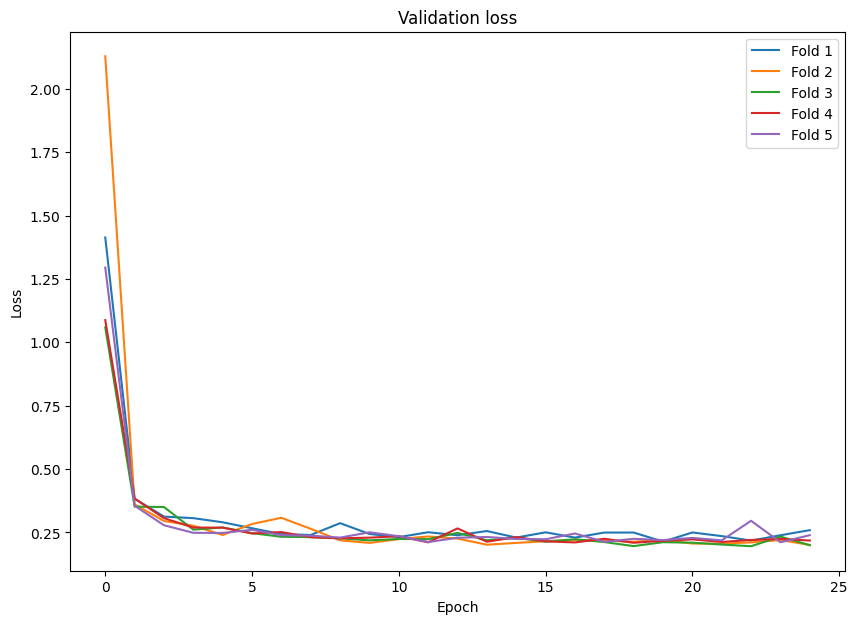

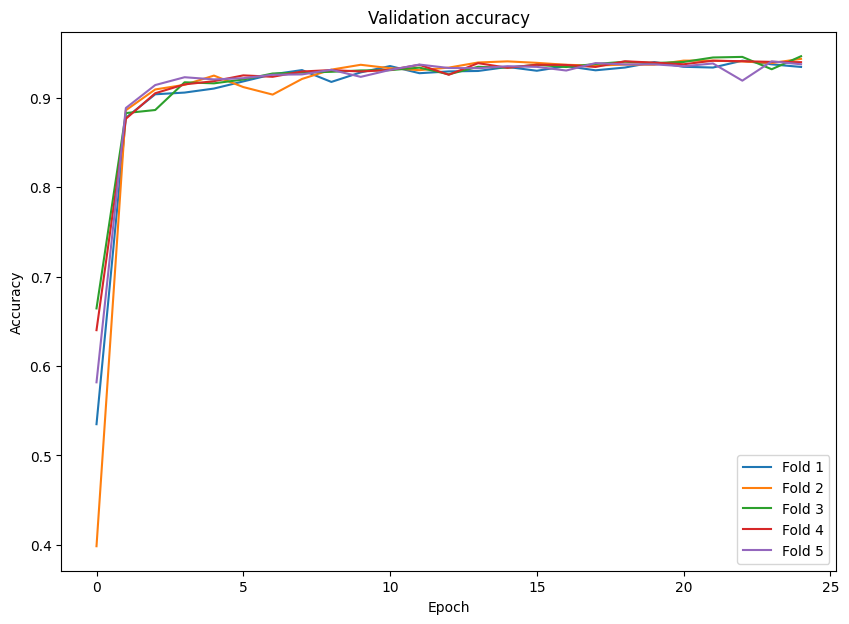

In [77]:
### Show 5-fold CV results
# Plot the loss and accuracy for each fold on the same plot
plt.figure(figsize=(10, 7))
for i in range(len(fold_losses)):
    plt.plot(fold_losses[i], label=f"Fold {i+1}")
plt.title('Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(10, 7))
for i in range(len(fold_accuracies)):
    plt.plot(fold_accuracies[i], label=f"Fold {i+1}")
plt.title('Validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

### Extraction of stats

In [78]:
all_accuracies = np.array([np.array(a) for a in fold_accuracies])
all_losses = np.array([np.array(l) for l in fold_losses])

# print last accuracy and loss
print((all_accuracies[:,-1]))
print((all_losses[:,-1]))

# extract mean and std of the accuracies of the last epoch
mean_accuracy = np.mean(all_accuracies[:,-1])
std_accuracy = np.std(all_accuracies[:,-1])
print("Mean accuracy:", mean_accuracy)
print("Std accuracy:", std_accuracy)

[0.93458331 0.94366664 0.94658333 0.93991667 0.93758333]
[0.25890189 0.20041099 0.19947398 0.21785676 0.23909548]
Mean accuracy: 0.9404666543006897
Std accuracy: 0.004263413158632185


### Test performances on the test set

In [83]:
# Evaluate the best model on the test set
accuracies_test = []
losses_test = []
for model in model_folds:
    loss, accuracy = model.evaluate(test_images, test_labels)
    accuracies_test.append(accuracy)
    losses_test.append(loss)

print("Test accuracies:", accuracies_test)
print("Test losses:", losses_test)

# Get mean and std of the test accuracies and losses
mean_test_accuracy = np.mean(accuracies_test)
std_test_accuracy = np.std(accuracies_test)
mean_test_loss = np.mean(losses_test)
std_test_loss = np.std(losses_test)


print("Mean test accuracy:", mean_test_accuracy, "Std:", std_test_accuracy)
print("Mean test loss:", mean_test_loss, "Std:", std_test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9268 - loss: 0.2748
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9350 - loss: 0.2276
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9356 - loss: 0.2511
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9343 - loss: 0.2567
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9284 - loss: 0.2627
Test accuracies: [0.9350000023841858, 0.9433000087738037, 0.944599986076355, 0.9429000020027161, 0.9388999938964844]
Test losses: [0.24723407626152039, 0.19982527196407318, 0.21398065984249115, 0.22103378176689148, 0.2285650670528412]
Mean test accuracy: 0.940939998626709 Std: 0.003528510845114235
Mean test loss: 0.22212777137756348 Std: 0.015727295001105875


# Statistical comparison of the 2 models

In [91]:
#Recapitulate the results on the 5-fold cross-validation for the test set
acc_test_cnn = [0.9350000023841858, 0.9433000087738037, 0.944599986076355, 0.9429000020027161, 0.9388999938964844]
acc_test_dnn = [0.838699996471405, 0.8370000123977661, 0.8374000191688538, 0.8292999863624573, 0.833299994468689]

 
#  Compare the two models with the Wilcoxon signed-rank test
stat, p = wilcoxon(acc_test_dnn, acc_test_cnn)

print("The associated p-value is", p)




The associated p-value is 0.0625
